In [1]:
import numpy as np
import glob
import os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
import scipy as sp

par = Params()
par.hdr
cmap = 'inferno'  # 'gray_r'
cmap = 'viridis'

Populating the interactive namespace from numpy and matplotlib


# Construct fake PSF and associated matched filter

1.0
0.0345183948114


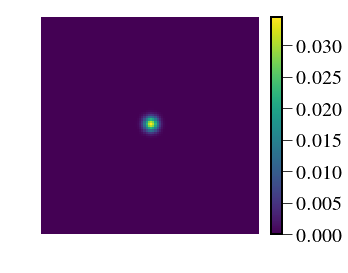

In [2]:
size = 100
FWHM = 5
sigma = FWHM/2.35
threshold=0.2
from scipy.special import erf
x = np.arange(size)-size//2
x,y = np.meshgrid(x,x)
psf = (erf((x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((y - 0.5) / (np.sqrt(2) * sigma)))

psf /= np.sum(psf)

plt.imshow(psf,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

normalized = psf/np.sum(psf)
msk = normalized>np.max(normalized)*threshold
aper_phot = np.sum(normalized)/np.sum(normalized[msk])
normalized[~msk]=0.0
normalized /= np.sum(normalized)


mf = normalized/np.sum(normalized**2)*aper_phot

print np.sum(psf*mf)
print np.amax(psf)
from crispy.tools.image import Image
from crispy.tools.detector import readDetector


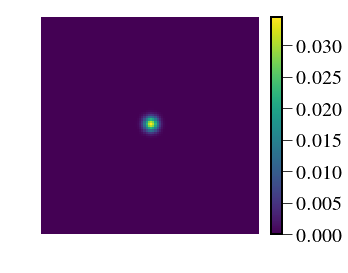

In [3]:
x = np.arange(size)-size//2
x,y = np.meshgrid(x,x)
psf = (erf((x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((y - 0.5) / (np.sqrt(2) * sigma)))

psf /= np.sum(psf)

plt.imshow(psf,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

normalized = psf/np.sum(psf)
msk = normalized>np.max(normalized)*threshold
aper_phot = np.sum(normalized)/np.sum(normalized[msk])
normalized[~msk]=0.0
normalized /= np.sum(normalized)


mf2 = normalized/np.sum(normalized**2)*aper_phot


Flux: 0.014485
Matched filter: 0.014485


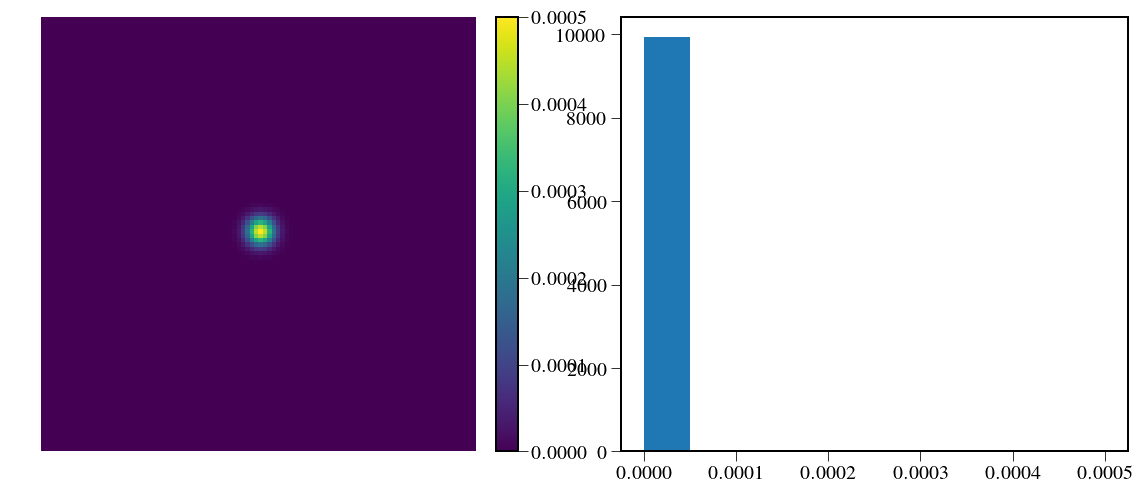

In [4]:
flux = 5e-4/np.amax(psf)
print "Flux: %f" % flux
Nimg = 1000
inttime = 50.
img = psf*flux

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(img,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(img,-1),10)

print "Matched filter: %f" % (np.sum(img*mf))

## Poisson process

0.0005
0
10
20
30
40
50
60
70
80
90
Matched filter: 0.014485 +/- 0.000000


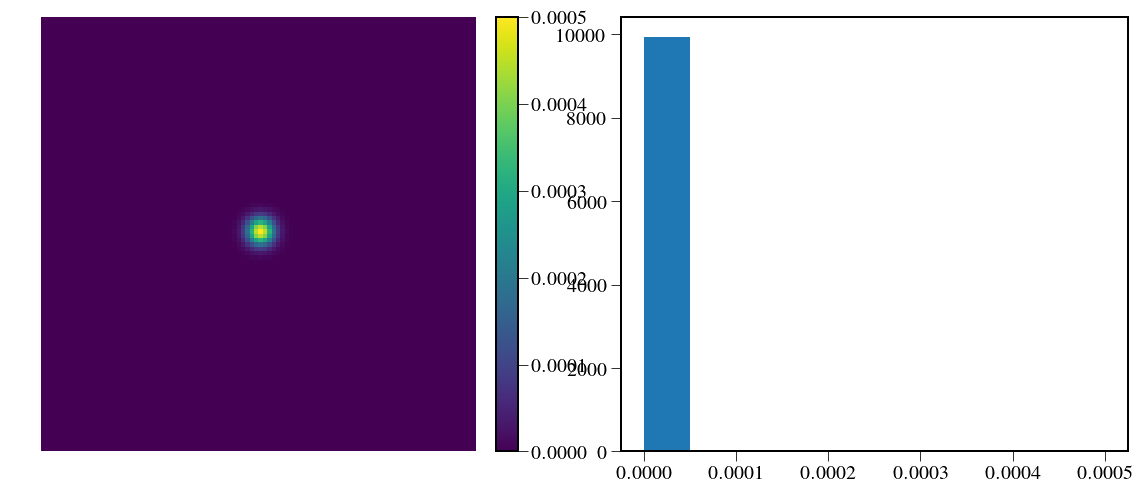

In [13]:
par.losses=1.0
par.nonoise=True
par.poisson=False
par.EMStats=False
par.EMGain = 200.0
par.RN=0.0
par.PCbias=0.0
par.PCmode=False
par.lifefraction = 0.0
par.dark = 0.0001
par.CIC=0.01

niter = 100
results = np.zeros(niter)
print np.amax(img)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= np.float(Nimg)
#     results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
    results[j] = np.sum((atEMRegister/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))


0
10
20
30
40
50
60
70
80
90
Matched filter: 0.014571 +/- 0.000757


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                  2.0 / Interlacing                                    
PHILENS =    26.565051177077

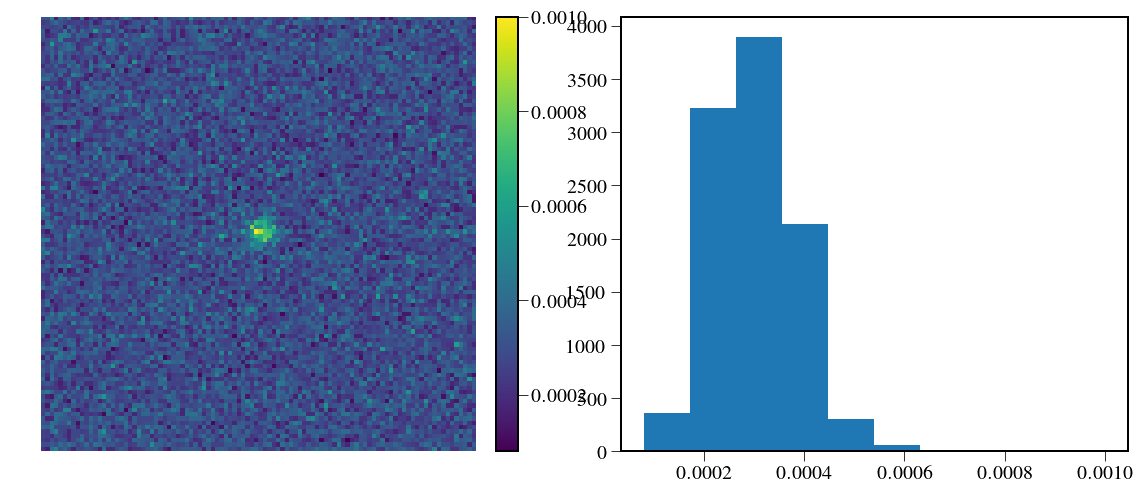

In [14]:
from crispy.tools.image import Image
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=False
par.EMGain = 200.0
par.RN=0.0
par.PCbias=0.0
par.PCmode=False
par.lifefraction = 0.0

niter = 100
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
    results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
#     results[j] = np.sum((atEMRegister/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))
par.hdr

## Electron multiplying stage

0
10
20
30
40
50
60
70
80
90
Matched filter: 0.014378 +/- 0.001265


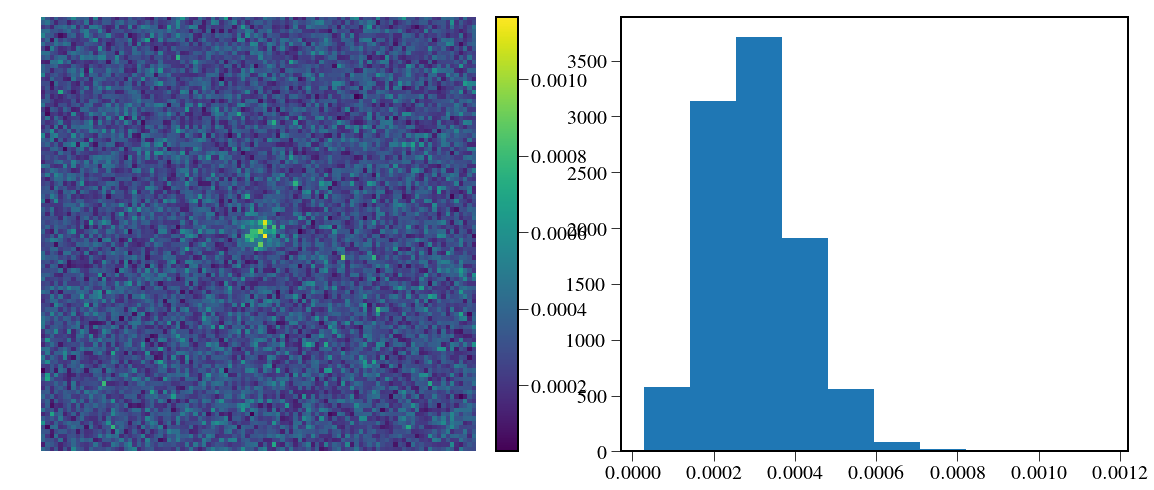

In [7]:
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=True
par.EMGain = 2000.0
par.RN=0.0
par.PCbias=0.0
par.PCmode=False
par.lifefraction = 0.0

niter = 100
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
    results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))

0
10
20
30
40
50
60
70
80
90
Matched filter: 0.008185 +/- 0.000801


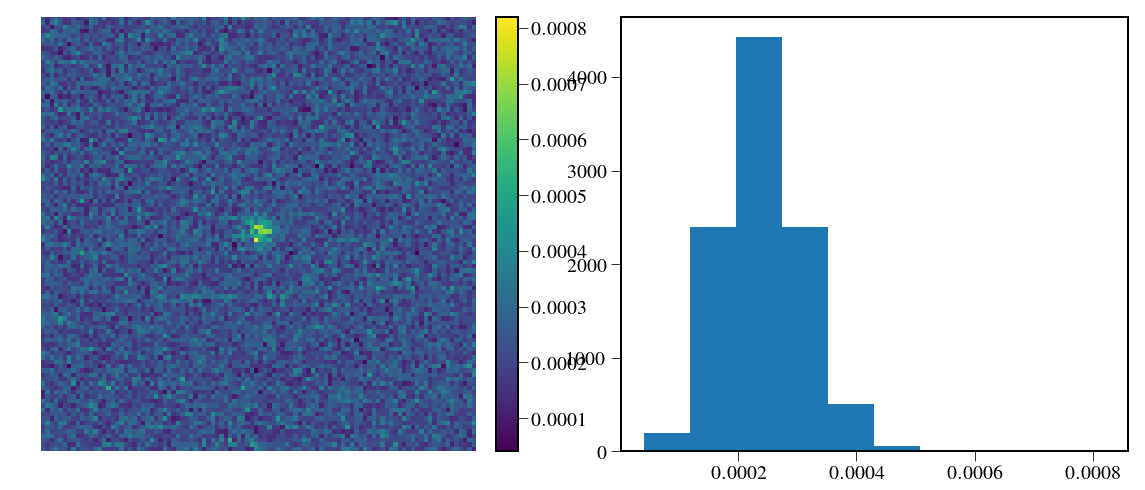

In [8]:
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=True
par.EMGain = 2500.0
par.RN=100.0
par.PCbias=0.0
par.PCmode=True
par.threshold = 6.
par.lifefraction = 0.0

niter = 100
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
    results[j] = np.sum((atEMRegister/inttime-par.dark-par.CIC/inttime)*mf)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister/inttime,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister/inttime,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))

In [9]:
par.losses=1.0
par.nonoise=False
par.poisson=True
par.EMStats=True
par.EMGain = 2500.0
par.RN=100.0
par.PCbias=2000.0
par.PCmode=True
par.threshold = 5
par.lifefraction = 0.0

niter = 10
results = np.zeros(niter)
for j in range(niter):
    if j%10==0:
        print j
    atEMRegister = np.zeros(img.shape)
    for i in range(Nimg):
        atEMRegister += readDetector(par,Image(data=img),inttime)

    atEMRegister /= Nimg
#     results[j] = np.sum((atEMRegister/inttime)*mf)-np.sum((atEMRegister/inttime)*mf2)
    results[j] = np.sum(((atEMRegister-np.mean(atEMRegister))/inttime)*mf)
#     results[j] = np.sum((atEMRegister/inttime)*mf)

0


Matched filter: 0.011596 +/- 0.000379


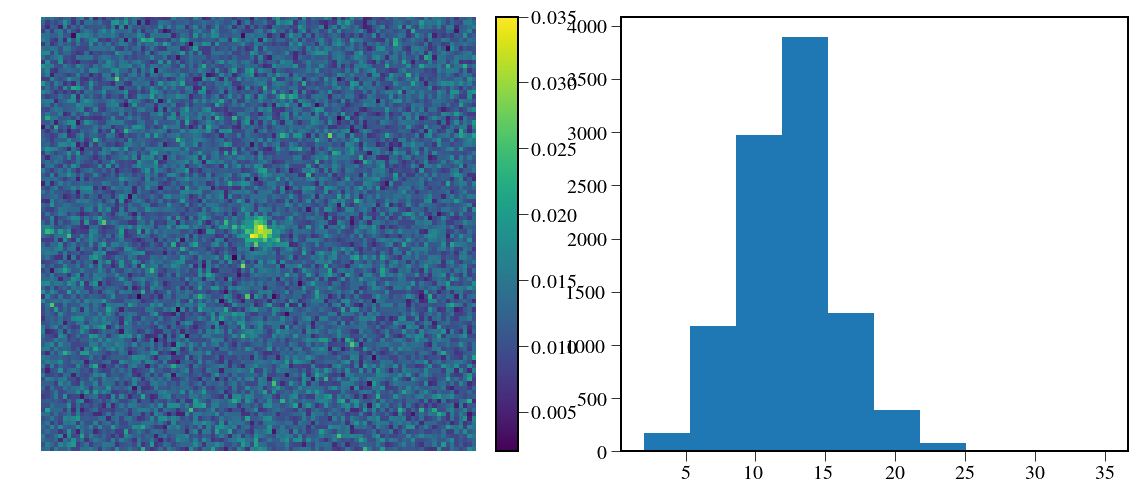

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(atEMRegister,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
n, bins, patches = plt.hist(np.reshape(atEMRegister*Nimg,-1),10)

print "Matched filter: %f +/- %f" % (np.mean(results),np.std(results))

In [11]:
np.mean(results)/np.exp(-500./par.EMGain)

0.014163036371964605

In [12]:
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                  2.0 / Interlacing                                    
PHILENS =    26.565051177077

# Matched filter formula check

5.30039255932
10.1537701315
21.5343857834


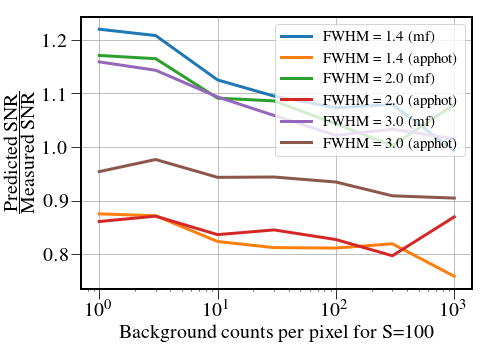

In [127]:
from scipy.special import erf
from photutils import aperture_photometry
from photutils import CircularAperture
size = 100
positions = [(size//2, size//2)]

# FWHM = 1.4
FWHMs = [1.4,2.0,3.]
plt.figure(figsize=(7,5))
for FWHM in FWHMs:
    sigma = FWHM/2.35
    threshold=0.2
    apertures = CircularAperture(positions, r=0.6*FWHM)

    x = np.arange(size)-size//2
    x,y = np.meshgrid(x,x)
    psf = (erf((x + 0.5) / (np.sqrt(2) * sigma)) - \
        erf((x - 0.5) / (np.sqrt(2) * sigma))) * \
        (erf((y + 0.5) / (np.sqrt(2) * sigma)) - \
        erf((y - 0.5) / (np.sqrt(2) * sigma)))

    psf /= np.sum(psf)

    normalized = psf/np.sum(psf)
    msk = normalized>np.max(normalized)*threshold
    aper_phot = np.sum(normalized)/np.sum(normalized[msk])
    normalized[~msk]=0.0
    normalized /= np.sum(normalized)

    mf = normalized/np.sum(normalized**2)*aper_phot



    bglist = [1.,3.,10.,30.,100.,300.,1000.]
    flux=100.
    niter = 1000
    beta = 1./np.sum(psf**2)
    print beta
    predicted=[]
    measured=[]
    apphot=[]
    predictedphot=[]
    res=[]
    apres=[]
    for bg in bglist:
        newimg = np.zeros((size,size))
        newimg+=bg
        newimg += psf*flux
        results = np.zeros(niter)
        apresults = np.zeros(niter)
        phot_table_ref = aperture_photometry(newimg-bg, apertures)
        predflux = phot_table_ref['aperture_sum'][0]
        for i in range(niter):
            pnewimg = np.random.poisson(newimg+1e-11)-bg
            results[i] = np.sum(pnewimg*mf)
            phot_table = aperture_photometry(pnewimg, apertures)
            apresults[i] = phot_table['aperture_sum'][0]
        # print beta
        predicted.append(flux/np.sqrt(flux+beta*bg))
        measured.append(np.mean(results)/np.std(results))
        apphot.append(np.mean(apresults)/np.std(apresults))
        predictedphot.append(predflux/np.sqrt(predflux+apertures.area()*bg))
        res.append(np.mean(results))
        res.append(np.mean(apresults))
    # print predicted,measured
    predicted = np.array(predicted)
    predictedphot = np.array(predictedphot)
    measured = np.array(measured)
    apphot = np.array(apphot)
    res = np.array(res)
    apres = np.array(apres)
    plt.semilogx(bglist,predicted/measured,lw=3,label='FWHM = {:} (mf)'.format(FWHM))
    plt.semilogx(bglist,predictedphot/apphot,lw=3,label='FWHM = {:} (apphot)'.format(FWHM))
plt.grid('on')
plt.xlabel(r'Background counts per pixel for $S=100$')
plt.ylabel(r'$\frac{\textrm{Predicted SNR}}{\textrm{Measured SNR}}$')
plt.legend()

Text(0,0.5,u'$\\frac{\\textrm{Predicted SNR}}{\\textrm{Measured SNR}}$')

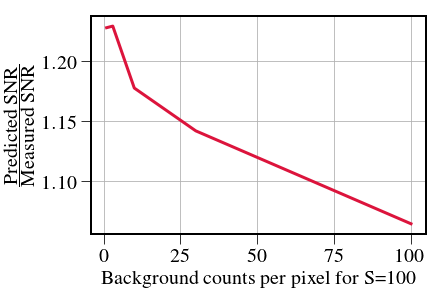

In [104]:
plt.plot(bglist,predicted/measured,color='crimson',lw=3,label=r'$\frac{\textrm{Predicted SNR}}{\textrm{Measured SNR}}$')
plt.grid('on')
plt.xlabel('Background counts per pixel for S=100')
plt.ylabel(r'$\frac{\textrm{Predicted SNR}}{\textrm{Measured SNR}}$')
# plt.legend(fontsize=20)

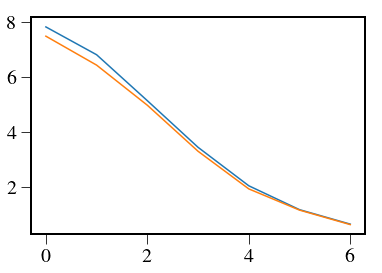

In [128]:
plt.plot(measured)
plt.plot(apphot)

In [125]:
print predflux

49.5000177826
